### Computer Model Distributions Notebook

 This notebook is used to generate a distribution plot for trained models.

In [3]:
import os
import argparse
import shutil
import numpy as np
import imageio
import time
import torch
import sys


sys.path.insert(0, "../../SemanticStyleGAN")
from models import make_model
from visualize.utils import generate
import matplotlib.pyplot as plt

In [30]:


## This function is different than the one in Control class in that takes image as 4 dimensional input
def from_rgb_to_label(image, color_map):
    color_map_sum = {}
    for c in color_map:
        color_map_sum[c] = sum(color_map[c])
    image_tensor = torch.tensor(image).to(float)
    image_summed = torch.sum(image_tensor, dim=3)
    for index in color_map_sum:
        image_summed=torch.where(image_summed==color_map_sum[index],torch.tensor(index),image_summed)
    return image_summed

In [51]:
def generate_model_dist_plot(ckpt,color_map,labels,samples=10,truncation_mean=10_000,batch=8):
    device="cpu"
    ckpt = torch.load(ckpt, map_location=torch.device("cpu"))
    model = make_model(ckpt["args"])
    model.to(device)
    model.eval()
    model.load_state_dict(ckpt["g_ema"])
    mean_latent = model.style(
        torch.randn(truncation_mean, model.style_dim, device=device)
    ).mean(0)

    print("Generating images ...")
    start_time = time.time()
    with torch.no_grad():
        styles = model.style(
            torch.randn(samples, model.style_dim, device=device)
        )
        _, segs = generate(
            model, styles, mean_latent=mean_latent, batch_size=batch
        )
    segs_converted = from_rgb_to_label(segs,color_map)
    class_dist = torch.bincount(segs_converted.int().flatten())
    class_dist = class_dist/class_dist.sum()## Sum
    print(class_dist)
    bar=plt.bar(color_map.keys(),class_dist)
    plt.xticks(list(color_map.keys()),list(labels.values()),rotation='vertical')
    for c in color_map:
        color = color_map[c]
        rgb = [x/255 for x in color]
        bar[c].set_color(tuple(rgb))
    return class_dist


Initializing model with arguments:
{'aug': False,
 'base_layers': 2,
 'batch': 4,
 'channel_multiplier': 2,
 'checkpoint_dir': '/no_backups/g013/checkpoints/IDD_v5',
 'ckpt': None,
 'coarse_channel': 512,
 'coarse_size': 64,
 'd_reg_every': 16,
 'dataset': '/no_backups/g013/data/IDD/lmdb_datasets/lmdb_v3',
 'depth_layers': 6,
 'detach_texture': False,
 'distributed': True,
 'g_reg_every': 4,
 'inception': '/no_backups/g013/data/IDD/inception_models/inception_v3.pkl',
 'iter': 600001,
 'lambda_mask': 100.0,
 'latent': 512,
 'local_channel': 64,
 'local_layers': 10,
 'local_rank': 0,
 'lr': 0.002,
 'min_feat_size': 16,
 'mixing': 0.3,
 'n_gpu': 3,
 'n_mlp': 8,
 'n_sample': 16,
 'num_workers': 8,
 'path_batch_shrink': 2,
 'path_regularize': 0.5,
 'r1_img': 10,
 'r1_seg': 1000,
 'residual_refine': True,
 'save_every': 5000,
 'seg_dim': 13,
 'size': 256,
 'start_iter': 0,
 'transparent_dims': (10, 12),
 'viz_every': 2000}
Generating images ...
tensor([0.0000, 0.3928, 0.0108, 0.0097, 0.0073,

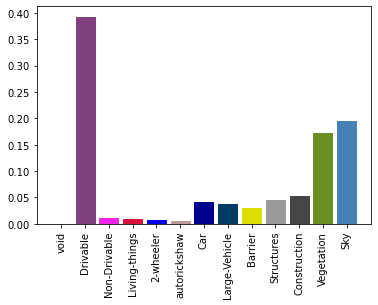

In [52]:
ckpt= "/no_backups/g013/checkpoints/IDD_v5/ckpt/025000.pt"

labels={
0: "void",
1: "Drivable" ,
2: "Non-Drivable",
3: "Living-things",
4: "2-wheeler",
5: "autorickshaw",
6: "Car",
7: "Large-Vehicle",
8: "Barrier",
9: "Structures",
10: "Construction",
11: "Vegetation",
12: "Sky"
}
color_map = {
    0: [0, 0, 0],  # Void
    1: [128, 64, 128],  # Drivable
    2: [244, 35, 232],  # Non-drivable
    3: [220, 20, 60],  # living Things
    4: [0, 0, 230],  # 2 wheeler
    5: [190, 153, 153],  # Rickshaw
    6: [0, 0, 142],  # Car
    7: [0, 60, 100],  # Large Vehicles
    8: [220, 220, 0],  # Barriers
    9: [153, 153, 153],  # Structures
    10: [70, 70, 70],  # Construction
    11: [107, 142, 35],  # Vegitation
    12: [70, 130, 180],  # Sky
}
class_dist = generate_model_dist_plot(ckpt,color_map,labels,samples=1_00)